In [1]:
# Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    f1_score,
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support
)

np.random.seed(42)

In [2]:
# Load Data

train_df = pd.read_csv('data/processed/train.csv')
val_df = pd.read_csv('data/processed/val.csv')
test_df = pd.read_csv('data/processed/test.csv')

# Extract text and labels
X_train_text = train_df['text'].values
X_val_text = val_df['text'].values
X_test_text = test_df['text'].values

y_train = train_df['sentiment'].values
y_val = val_df['sentiment'].values
y_test = test_df['sentiment'].values

In [3]:
# Load class weights 
with open('data/processed/class_weights.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

print(f"Class weights: {class_weight_dict}")

Class weights: {0: 2.2781717214865442, 1: 4.0208082026538, 2: 0.4324613613142829}


In [4]:
vectorizer = TfidfVectorizer(
    max_features=5000,      # Keep only the 5,000 most important words
    min_df=2,               # Ignore words appearing in fewer than 2 documents (remove typos)
    max_df=0.95,            # Ignore words appearing in >95% of documents (too common)
    ngram_range=(1, 2),     # Use single words and word pairs ("great", "great game")
    strip_accents='unicode',
    lowercase=True
)

# Fit on training data and transform all splits
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(X_test_text)

print(f"  Train: {X_train_tfidf.shape}")
print(f"  Val:   {X_val_tfidf.shape}")
print(f"  Test:  {X_test_tfidf.shape}")

  Train: (79998, 5000)
  Val:   (10000, 5000)
  Test:  (10000, 5000)


In [5]:
# Show top features (most important words)
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:20])

['00' '10' '10 10' '100' '11' '12' '13' '14' '15' '16' '18' '1st' '20'
 '200' '24' '25' '2nd' '30' '34' '34 and']


In [6]:
# Train Logistic Regression Model 

model = LogisticRegression(
    max_iter=1000,
    class_weight=class_weight_dict,  
    random_state=42,
    solver='lbfgs',
    verbose=0
)

model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight={0: 2.2781717214865442, 1: 4.0208082026538,
                                 2: 0.4324613613142829},
                   max_iter=1000, random_state=42)

In [7]:
# Evaluate on Test Set

# Predictions
y_pred_train = model.predict(X_train_tfidf)
y_pred_val = model.predict(X_val_tfidf)
y_pred_test = model.predict(X_test_tfidf)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)
test_acc = accuracy_score(y_test, y_pred_test)

# Calculate macro F1 (equally weights all classes)
train_f1 = f1_score(y_train, y_pred_train, average='macro')
val_f1 = f1_score(y_val, y_pred_val, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro')

print(f"\nTrain Accuracy:  {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Train Macro F1:  {train_f1:.4f} ({train_f1*100:.2f}%)")
print(f"\nVal Accuracy:    {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Val Macro F1:    {val_f1:.4f} ({val_f1*100:.2f}%)")
print(f"\n✨ Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"✨ Test Macro F1:  {test_f1:.4f} ({test_f1*100:.2f}%)")


Train Accuracy:  0.8207 (82.07%)
Train Macro F1:  0.7124 (71.24%)

Val Accuracy:    0.7905 (79.05%)
Val Macro F1:    0.6476 (64.76%)

✨ Test Accuracy:  0.7729 (77.29%)
✨ Test Macro F1:  0.6243 (62.43%)


In [8]:
# Classification Report 

class_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred_test, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    Negative     0.6306    0.7163    0.6707      1463
     Neutral     0.2328    0.5199    0.3216       829
    Positive     0.9635    0.8108    0.8806      7708

    accuracy                         0.7729     10000
   macro avg     0.6090    0.6824    0.6243     10000
weighted avg     0.8542    0.7729    0.8036     10000



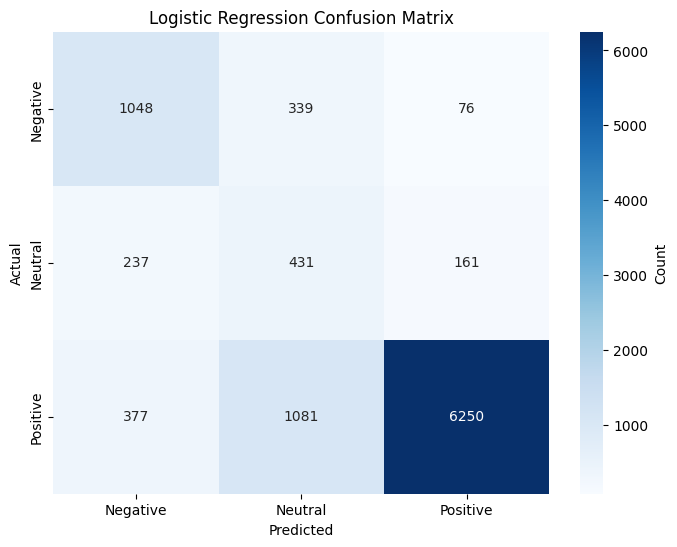

In [9]:
# Confusion Matrix 

cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
ax.set_title('Logistic Regression Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.savefig('results/figures/baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


Per-Class Performance:
   Class  Precision   Recall  F1-Score  Support
Negative   0.630566 0.716336  0.670720     1463
 Neutral   0.232847 0.519903  0.321642      829
Positive   0.963465 0.810846  0.880592     7708


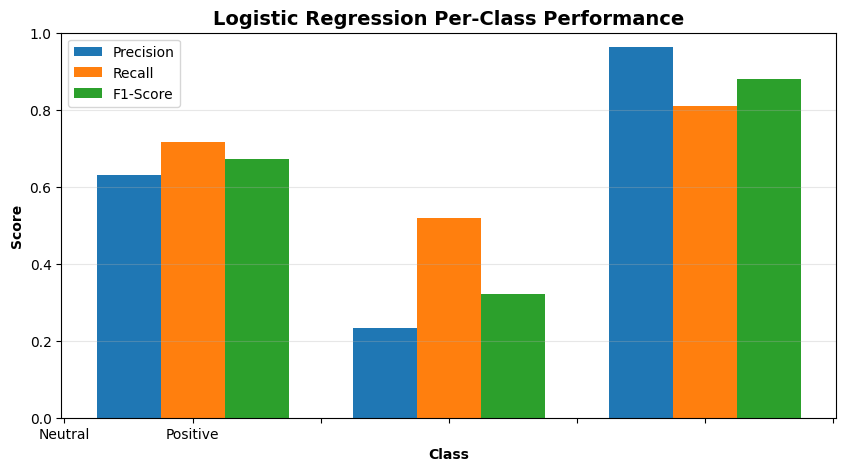

In [10]:
# Per-Class Performance 

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test)

perf_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-Class Performance:")
print(perf_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-Score')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Logistic Regression Per-Class Performance', fontsize=14, fontweight='bold')
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.savefig('results/figures/baseline_per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Error Analysis 

# Find misclassified examples
errors = y_test != y_pred_test
error_indices = np.where(errors)[0]

print(f"\nTotal errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")

# Count errors by true class
print("\nErrors by class:")
for i, class_name in enumerate(class_names):
    class_mask = y_test == i
    class_errors = np.sum(errors & class_mask)
    class_total = np.sum(class_mask)
    print(f"  {class_name}: {class_errors}/{class_total} ({class_errors/class_total*100:.1f}%)")


Total errors: 2271 / 10000 (22.71%)

Errors by class:
  Negative: 415/1463 (28.4%)
  Neutral: 398/829 (48.0%)
  Positive: 1458/7708 (18.9%)


In [12]:
# Most Influential Features 

# Get feature weights for each class
feature_names = vectorizer.get_feature_names_out()
class_labels = ['Negative', 'Neutral', 'Positive']

for i, class_label in enumerate(class_labels):
    coefficients = model.coef_[i]
    top_indices = np.argsort(coefficients)[-10:][::-1]
    top_features = [(feature_names[idx], coefficients[idx]) for idx in top_indices]
    
    print(f"{class_label} indicators:")
    for feature, coef in top_features:
        print(f"  {feature:20s} ({coef:.3f})")
    print()

Negative indicators:
  garbage              (4.743)
  worst                (4.563)
  not worth            (4.330)
  not                  (4.293)
  terrible             (4.013)
  crap                 (4.003)
  horrible             (3.935)
  poorly               (3.840)
  return               (3.839)
  disappointed         (3.804)

Neutral indicators:
  however              (3.793)
  but                  (3.276)
  ok                   (2.971)
  interest             (2.762)
  though               (2.589)
  okay                 (2.569)
  lacking              (2.563)
  major                (2.204)
  you ve               (2.200)
  unfortunately        (2.173)

Positive indicators:
  great                (7.053)
  perfect              (5.548)
  awesome              (4.917)
  amazing              (4.605)
  perfectly            (4.196)
  love                 (4.136)
  happy                (4.087)
  best                 (3.978)
  excellent            (3.900)
  glad                 (3.864)



In [13]:
# Save Results

results = {
    'model': 'Logistic Regression (TF-IDF)',
    'test_accuracy': float(test_acc),
    'test_macro_f1': float(test_f1),
    'val_accuracy': float(val_acc),
    'val_macro_f1': float(val_f1),
    'precision': precision.tolist(),
    'recall': recall.tolist(),
    'f1': f1.tolist(),
    'confusion_matrix': cm.tolist(),
    'parameters': 'N/A (traditional ML)',
    'features': X_train_tfidf.shape[1]
}

with open('results/metrics/baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save predictions
np.save('results/metrics/baseline_predictions.npy', y_pred_test)